<a href="https://colab.research.google.com/github/sumanthd17/Airbnb-Valuator/blob/master/AirbnbValuator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
path = '/content/drive/My Drive/AB_NYC_2019.csv'
data = pd.read_csv(path)
data.head()

print('samples: {}'.format(data.shape[0]))
print('Features: {}'.format(data.shape[1]))
data.dtypes

samples: 48895
Features: 16


id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [0]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

# Preprocessing the Data


In [48]:
total = data.isnull().sum().sort_values(ascending=False)
percent = data.isnull().sum() / total
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=False)
missing_data

,Total,%
reviews_per_month,10052,1.0
last_review,10052,1.0
host_name,21,1.0
name,16,1.0
availability_365,0,NaN
calculated_host_listings_count,0,NaN
number_of_reviews,0,NaN
minimum_nights,0,NaN
price,0,NaN
room_type,0,NaN


In [0]:
data.drop(['host_name', 'name'], axis=1, inplace=True)

In [0]:
# data[data['number_of_reviews']==0].shape
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [0]:
earliest_review = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest_review)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest_review.toordinal())

# Check Distributions

In [52]:
data.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [0]:
# dropping host_id and id
data = data.drop(['host_id', 'id'], axis=1)

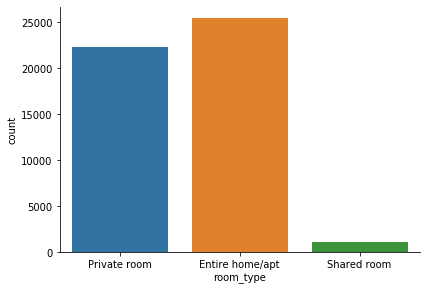

In [54]:
# Distribution of room types
sns.catplot(x='room_type', kind='count', data=data)
fig = plt.gcf()
fig.set_size_inches(6, 4)

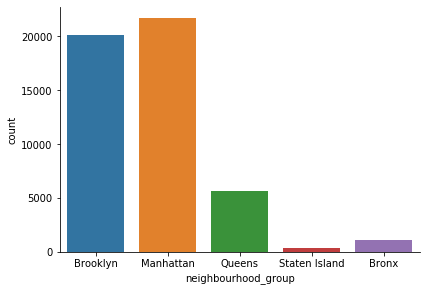

In [60]:
# neighbourhood distribution

sns.catplot(x='neighbourhood_group', kind='count', data=data)
fig = plt.gcf()
fig.set_size_inches(6, 4)

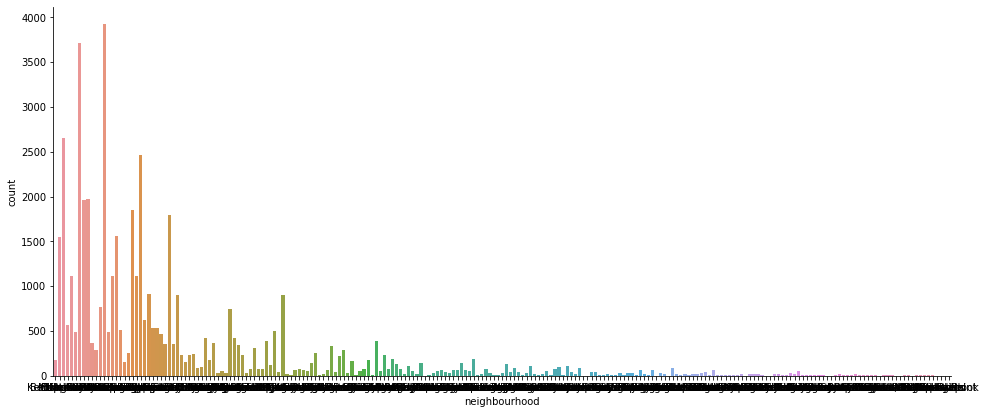

In [62]:
# neighbourhood distribution

sns.catplot(x='neighbourhood', kind='count', data=data)
fig = plt.gcf()
fig.set_size_inches(18, 6)

(0, 365)

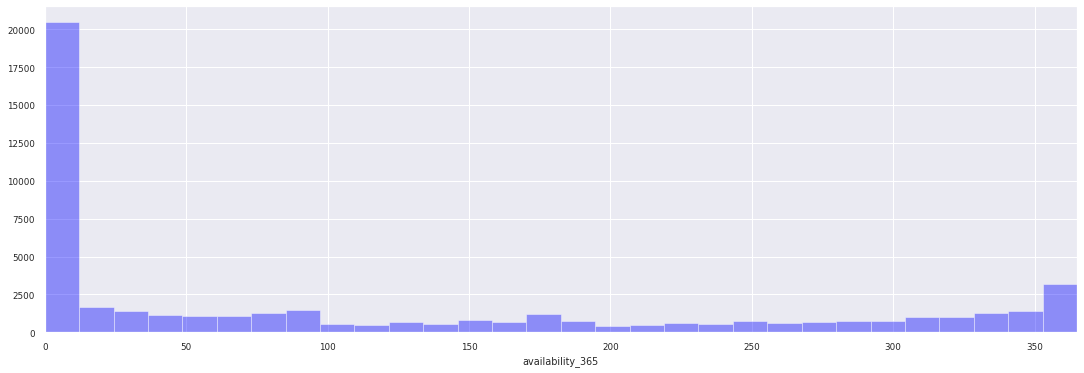

In [64]:
# Availability Distribution

fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

In [0]:
# changing thresholds

data['all_year_available'] = data['availability_365'] > 350
data['low_availability'] = data['availability_365'] < 15
data['no_reviews'] = data['reviews_per_month'] == 0

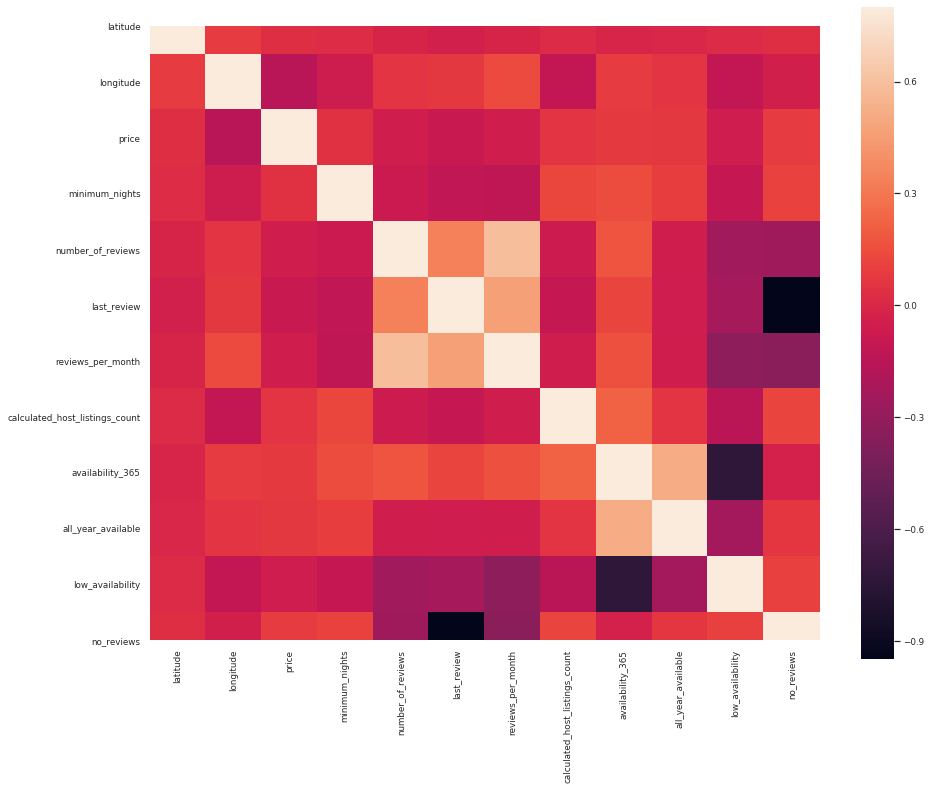

In [66]:
# Correlation Matrix

correlation = data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(correlation, vmax=0.8, square=True)
sns.set(font_scale=0.8)

No strong correlation between the values

In [25]:
data.head()
data.dtypes

id                                         int64
host_id                                    int64
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object